# 2．線形回帰モデルを通して｢解釈性｣を理解する

* 線形回帰モデルが備える解釈性
    1. 特徴量と予測値の平均的な関係
    2. 特徴量と予測値のインスタンスごとの関係
    3. 特徴量の重要度
    4. インスタンスごとの予測の理由

1. 特徴量と予測値の平均的な関係
2. 特徴量と予測値のインスタンスごとの関係
3. 特徴量の重要度
4. インスタンスごとの予測の理由

In [9]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any # 型ヒント用
from __future__ import annotations # 型ヒント用

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston
warnings.simplefilter('ignore')

In [10]:
# load data
boston = load_boston()
X = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
y = boston['target']

print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [16]:
def plot_histgram(x, title=None, x_label=None):
    fig, ax = plt.subplots()
    # sns.distplot(x, kde=False, ax=ax)
    ax.hist(x, bins=30, ec='black')
    fig.suptitle(title)
    ax.set_xlabel(x_label)
    
    fig.show()

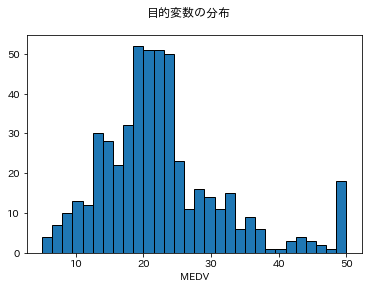

In [17]:
plot_histgram(y, title='目的変数の分布', x_label='MEDV')

In [ ]:
* 少し⇨に